# ECMs

This module contains different types of episodic and compositional memories (ECMs)

In [ ]:
#| default_exp ECMs

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

# ECMs constructors

Here we collect different standalone functions that will help us construct different types of ECM

## ECM updaters

In [ ]:
#| export
def standard_ps_upd(reward, hmatrix, gmatrix, h_damp, g_damp):
    """
    Given a reward, updates h-matrix and g-matrix following the standard PS update rule:

    h <- h - h_damp*(h-1)+ reward*g
    g <- (1-g_damp)*g    
    """
    # damping h-matrix
    hmatrix = hmatrix - h_damp*(hmatrix-1.)
    # update h-matrix
    hmatrix += reward*gmatrix
    # update g-matrix
    gmatrix = (1-g_damp)*gmatrix

    return hmatrix, gmatrix

# Pre-built ECMs

Here we collect the abstract parent class that any ECM should be built upon as well as some pre-built ECM ready to use.

#| hide

## Abstract ECM

In [ ]:
#| export
from projective_simulation.methods.lib_helpers import CustomABCMeta
from abc import abstractmethod


class Abstract_ECM(metaclass = CustomABCMeta):
    """
    Abstract agent class any episodic and compositional memory (ECM) should be derived from. Asserts that the necessary methods are implemented.
    """

    def __init__(self):
        '''
        No restrictions on the constructor, as the ECM can be anything that has a sample module.
        '''
        pass

    @abstractmethod
    def sample(self,):
        """
        Performs a random walk through the ECM. Typically, this implies receiving an input percept and returning an action.
        """
        pass

In [ ]:
#| hide

### Test ###

class test_abstract(Abstract_ECM):

    def __init__(self, num_actions = 2):
        self.num_actions = num_actions

        super().__init__()

    # Here we do not define on purpose the sample method, to check if the abstract class raises an error when trying to instantiate it.
    # def sample(self):
    #     return 0

try:
    agent = test_abstract()  # This should raise a TypeError
except TypeError:
    print("Got the expected TypeError, test passed.")
else:
    raise AssertionError("TestAgent() did NOT raise TypeError but it should have.") 


Got the expected TypeError, test passed.


## Two Layer ECMs

### Basic Two Layer

In [ ]:
#| export
import numpy as np
from projective_simulation.methods.transforms import _softmax

class Two_Layer(Abstract_ECM):
    def __init__(self, 
                 # The number of available actions.
                 num_actions: int, 
                 # The glow damping(or eta) parameter. 
                 g_damp: float, 
                 # The damping (or gamma) parameter. 
                 h_damp: float,
                 # If 'greedy', uses a greedy policy that samples the most action based on the h-matrix. 
                 # If 'softmax', uses a softmax policy that samples an action based on the h-matrix and a temperature parameter (encoded in policy_parameters).
                 # If object, uses this object to sample action. Input must be h_values corresponding to current percept + arbitrary policy_parameters.
                 policy: str = 'greedy',                 
                 # The parameters of the policy.
                 policy_parameters: dict = None,
                 # Method to update the g-matrix. 
                 # If 'sum', adds the new value to the current value.
                 # If 'init', sets the new value to 1.
                 glow_method: str = 'sum',
                ):

        """
        Two layer ECM. First layer, encoding the percepts observed in an environment, is initially empty (e.g. self.num_percepts = 0). As percepts
        are observed, they are added to the ECM and to the percept dictionary self.percepts. 
        The second layer, encoding the actions, has size self.num_actions.
        In practice, the ECM graph is never created. Instead, it is defined indirectly by the h-matrix and g-matrix. 
        Both have size (self.num_percepts, self.num_actions). 
        The input policy (greedy, softmax or other) is used to sample actions based on the h-matrix.

        For an end-to-end example of how to use this class, see the tutorial notebook on Basic PS agents.        
        """

        

        self.num_actions = num_actions

        self.h_damp = h_damp
        self.g_damp = g_damp
        self.glow_method = glow_method

        self.policy = policy
        self.policy_parameters = policy_parameters
        
        # Initialize ECM structures

        #int: current number of percepts.
        self.num_percepts = 0
        #np.ndarray: h-matrix with current h-values. Defaults to all 1.
        self.hmatrix = np.ones([0,self.num_actions])
        #np.ndarray: g-matrix with current glow values. Defaults to all 0.
        self.gmatrix = np.zeros([0,self.num_actions])
        #dict: Dictionary of percepts as {"percept": index}
        self.percepts = {}

    def sample(self, percept: str):
        """
        Given a percept, returns an action and changes the ECM if necessary
        First, if the percept is new, it will be added to the ECM
        Then, an action is selected as a function of the percept and the h-values of edges connected to that percept
        Finally, the g-matrix is updated based on the realized percept-action pair.
        """

        # Add percept to ECM if not already present
        self.add_percept(percept)
        # Get index from dictionary entry
        percept_index = self.percepts[percept]
        # Get h-values
        h_values = self.hmatrix[percept_index]

        # Perform Random Walk through the ECM based on h_values and current policy
        if self.policy == 'greedy': 
            # Sample greedly the action with the highest h-value
            h_values = self.hmatrix[percept_index]
            action = h_values.argmax()   

        elif self.policy == 'softmax':
            # Get probabilities from h-values through a softmax function
            prob = _softmax(self.policy_parameters, h_values)
            # Sample action based on probabilities
            action = np.random.choice(range(self.num_actions), p=prob) 

        else:
            # This considers a custom policy
            action = self.policy(h_values = h_values, **self.policy_parameters)

        # Update g-matrix
        if self.glow_method == 'sum':
            self.gmatrix[int(percept_index),int(action)] += 1.
        if self.glow_method == 'init':
            self.gmatrix[int(percept_index),int(action)] = 1.   

        return action

    def add_percept(self, percept):
        '''
        Checks if percept is in dictionary and adds to ECM in not
        '''
        if percept not in self.percepts.keys(): 
            self.percepts[percept] = self.num_percepts
            # increment number of percepts
            self.num_percepts += 1
            # add column to h-matrix
            self.hmatrix = np.append(self.hmatrix, 
                                     np.ones([1,self.num_actions]),
                                     axis=0)
            # add column to g-matrix
            self.gmatrix = np.append(self.gmatrix, 
                                    np.zeros([1,self.num_actions]),
                                    axis=0)

    def learn(self, reward):
        """
        Updates the h-matrix and g-matrix based on the reward received using the standard PS update rule.
        """
        self.hmatrix, self.gmatrix = standard_ps_upd(reward, self.hmatrix, self.gmatrix, self.h_damp, self.g_damp)

In [ ]:
#| hide

### Test ###

# Greedy policy
ECM_2l_greedy = Two_Layer(4,1,1)
ECM_2l_greedy.sample(0)

# Softmax policy
ECM_2l_softmax = Two_Layer(4,1,1, policy = 'softmax', policy_parameters = 1)
ECM_2l_softmax.sample(0);

### Priming Two Layer

In [ ]:
#| export
from projective_simulation.methods import transforms

class Priming_ECM(Two_Layer):
    '''
    This sub-class of the Two-Layer ECM adds a variable for action priming.
    This variable should be a list of floats, each element of which corresponds to an action in the ECM.
    These "priming values" are summed with h-values of any edge connected to the associated action node prior to calculating walk probabilites with the softmax function
    '''
    def __init__(self, 
                 num_actions: int, # The number of available actions.                 
                 glow: float = 0.1, # The glow (or eta) parameter. 
                 damp: float = 0.01, # The damping (or gamma) parameter. 
                 softmax: float = 0.5, # The softmax (or beta) parameter.
                 action_primes: list = None, #weights on the probability that deliberation steps into each action. Defaults to 0 for each action 
                ):
        if action_primes is None:
            action_primes = [0.] * num_actions
        assert len(action_primes) == num_actions

        self.softmax = softmax
        super().__init__(num_actions, glow, damp, 
                         policy = None) # Here I made explicit that the policy is None, as we override the sample method
        self.action_primes = action_primes
        

    def sample(self, percept):
        '''
        Almost identical to the sample function of Two-Layer parent class, but sums h-values and action primes prior to calculating walk probabilities
        '''
        self.add_percept(percept)
        #Perform Random Walk
        # get index from dictionary entry
        percept_index = self.percepts[percept]
        # get h-values
        h_values = self.hmatrix[percept_index]
        #~~~Differences from two-layer sample function within
        assert len(h_values) == len (self.action_primes)
        # get probabilities from h-values and primes through a softmax function
        prob = transforms._softmax(self.softmax, h_values + self.action_primes)
        #~~~~~~~
        # get action
        action = np.random.choice(range(self.num_actions), p=prob)        
        #pdate g-matrix
        self.gmatrix[int(percept_index),int(action)] = 1.
        return action

#### Example

In [ ]:
#| hide
from projective_simulation.environments import RLGL
from projective_simulation.ECMs import Priming_ECM
import matplotlib.pyplot as plt

[<matplotlib.lines.Line2D>]

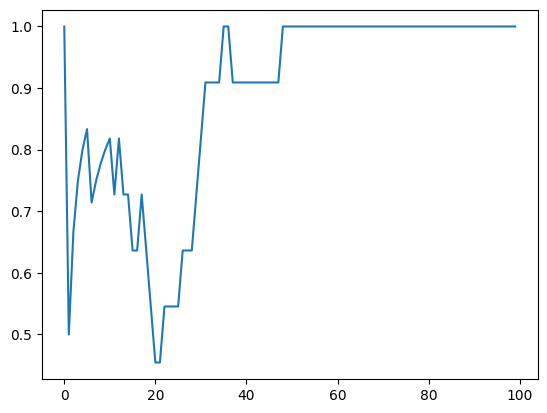

In [ ]:
test_ECM = Priming_ECM(num_actions = 2, action_primes = [0., 1.5])
#Number of steps to run simulation
T = 100
data_log = [None] * T
env = RLGL() #create a default red-light-green-light environment

for t in range(T):
    observation = env.get_observation()
    action = test_ECM.sample(observation)
    reward = env.get_reward(action)
    test_ECM.learn(reward)
    data_log[t] = {"env_state": env.state, "action": action, "reward": reward}
    env.transition(action)

plt.plot(range(T), [np.mean([data_log[step]["reward"] for step in range(i-10,i+1) if step >= 0]) for i in range(T)]) #plot a 10 step moving average of the reward 

#| hide
# nbdev export

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()